In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics
from scipy.spatial.distance import mahalanobis
import heapq

# Load data

In [2]:
batch_num = 8
hidden_num = 35
step_num = 30
elem_num = 34
init_wins = 1000

names = [str(x) for x in range(elem_num)] +["label"]
http = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/http_new.csv",names=names,skiprows=step_num*init_wins)
batches = http.shape[0]//step_num//batch_num
test_set = http.iloc[:batches*batch_num*step_num,:-1]
labels =http.iloc[:batches*batch_num*step_num,-1]

ts = test_set.as_matrix().reshape(batches,batch_num,step_num,elem_num)
test_set_list = [ts[a] for a in range(batches)]

In [3]:
labels[labels!="normal"] = "anomaly"

In [4]:
del http
del test_set

In [5]:
wins = batches * batch_num
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[405, 406, 407, 408, 409, 410, 411, 412, 597, 753, 986, 1089, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1658, 1806, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 9609, 10724, 14408, 14409, 14410, 14411, 14412, 14413, 14414, 14415, 14416, 14417, 14418, 14419, 14420, 14421, 14422, 14423, 14424, 14425, 14426, 14427, 14428, 14429, 14430, 14431, 14432, 14433, 14434, 14435, 14436, 14437, 14438, 14439, 14440, 14441, 14632, 14672, 14798, 14799, 14800, 14801, 14802, 14803, 14804, 14805, 14806, 14807, 14808, 14809, 14810, 14811, 14812, 14813, 14814, 14815, 14816, 14817, 14818, 14819, 14820, 14821, 14822, 14823, 14824, 14825, 14826, 14827, 14828, 14829, 14830, 14831, 15012, 15013, 15014, 15015, 15016, 15017, 15018, 15019, 15604, 16804, 17699, 17721, 19047]


# Load Model

In [6]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/http_8_35_30/"
modelmeta_p = modelpath_root + "_8_35_30_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/http_8_35_30/_8_35_30_para.ckpt


In [7]:
print(mu.shape,sigma.shape,threshold)

(34,) (34, 34) 0.0549761


# Online Phase (With expert)

In [8]:
def local_preprocessing(batchdata):
    # input batchdata with shape : [batch_num, step_num, elem_num]
    # minmax scaler on window level
    df = pd.DataFrame()
    
    for window in batchdata:
        
        scaler = MinMaxScaler()
        scaler.fit(window)
        new_win = scaler.transform(window)
        df = pd.concat((df, pd.DataFrame(new_win)),axis=0) if df.size!=0 else pd.DataFrame(new_win)
    return df.as_matrix().reshape(batchdata.shape)

    

In [9]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [10]:
def get_musigma(err_nbuf,mu,sigma):       
    
        err_vec_array = np.array(err_nbuf)
        # for multivariate  data
        mu = np.mean(err_vec_array,axis=0)
        sigma = np.cov(err_vec_array.T)
        return mu, sigma

In [11]:
def get_threshold(normal_score, abnormal_score):
        upper = np.median(np.array(abnormal_score))
        lower = np.median(np.array(normal_score)) 
        scala = 20
        delta = (upper-lower) / scala
        candidate = lower
        threshold = 0
        result = 0

        def evaluate(threshold,normal_score,abnormal_score):

            beta = 0.5
            tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
            fp = len(abnormal_score)-tp
            fn = np.array(normal_score)[np.array(normal_score)>threshold].size
            tn = len(normal_score)- fn

            if tp == 0: return 0

            P = tp/(tp+fp)
            R = tp/(tp+fn)
            fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
            return fbeta 

        for _ in range(scala):
            r = evaluate(candidate,normal_score,abnormal_score)
            if r > result:
                result = r 
                threshold = candidate
            candidate += delta 
        return threshold

In [12]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

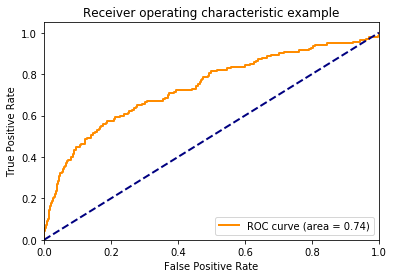

In [13]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
err_nbuf = []
err_abuf = []
all_scores = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
    
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in scores.as_matrix().reshape(batch_num,step_num)]
        output += [ss.max() for ss in scores.as_matrix().reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        e = [err.reshape(-1,elem_num)]
        for index,value in enumerate(pred):
            if value[value>threshold].size>=5: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf.append(df[index])
                    #err_abuf.append(e[index])
                    #err_abuf = err_abuf + e[index] if len(err_abuf) != 0 else e[index]
                else:
                    #print("FP")
                    #err_nbuf.append(e[index])
                    #err_nbuf = err_nbuf + e[index] if len(err_nbuf) != 0 else e[index]
                    n_buf.append(df[index])
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf.append(df[index])
                    #err_abuf.append(e[index])
                    #err_abuf = err_abuf + e[index] if len(err_abuf) != 0 else e[index]
                else:
                    pass
                    #err_nbuf.append(e[index])
                    #err_nbuf = err_nbuf + e[index] if len(err_nbuf) != 0 else e[index]
                    #print("TN")
        count +=1
        

        
        if len(n_buf)>=1600 and len(a_buf)>=1600:
            print("retrain at %d batch"%count)
            loss_list_all=[]

            datalist = np.array(n_buf[:6]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf[6:]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(30):
                
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            

            err_nbuf_tmp = np.array(err_nbuf).reshape(-1,elem_num)
            mu,sigma = get_musigma(err_nbuf_tmp,mu,sigma)

            normal_score = []
            abnormal_score = []
            
            for val in validation_list_n:
                (ein,aus) = sess.run([input_,output_], {p_input: val,p_is_training :False})
                
                err = abs(ein-aus).reshape(-1,elem_num)
        
                normal_score +=scoring(err,mu,sigma)
            
            for val_a in validation_list_a:
                (ein,aus) = sess.run([input_,output_], {p_input: val_a,p_is_training :False})
                
                err = abs(ein-aus).reshape(-1,elem_num)
        
                abnormal_score +=scoring(err,mu,sigma)
            
            threshold = get_threshold(normal_score, abnormal_score)
        
            print("Parameters updated!")
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()

In [13]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
err_nbuf = []
err_abuf = []
all_scores = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
    
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in scores.as_matrix().reshape(batch_num,step_num)]
        output += [ss.max() for ss in scores.as_matrix().reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        e = [err.reshape(-1,elem_num)]
        for index,value in enumerate(pred):
            if value[value>threshold].size>=5: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                    #err_abuf = err_abuf + e[index] if len(err_abuf) != 0 else e[index]
                else:
                    #print("FP")
                    err_nbuf.append(e[index])
                    #err_nbuf = err_nbuf + e[index] if len(err_nbuf) != 0 else e[index]
                    n_buf.append(df[index])
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                    #err_abuf = err_abuf + e[index] if len(err_abuf) != 0 else e[index]
                else:
                    pass
                    err_nbuf.append(e[index])
                    #err_nbuf = err_nbuf + e[index] if len(err_nbuf) != 0 else e[index]
                    #print("TN")
        count +=1
        

        
        if len(n_buf)>=batch_num*step_num*5:
            n_buf = n_buf[:batch_num*step_num*5]
            print("retrain at %d batch"%count)
            loss_list_all=[]

            datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
          
            for i in range(70):
                
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            

            err_nbuf_tmp = np.array(err_nbuf).reshape(-1,elem_num)
            mu,sigma = get_musigma(err_nbuf_tmp,mu,sigma)

            normal_score = []
            abnormal_score = []
            

            print("Parameters updated!")
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()

IndexError: list index out of range

0 : 0 ,  0
100 : 23700 ,  300
retrain at 102 batch
Parameters updated! new threshold 0.055
200 : 20370 ,  720
retrain at 220 batch
Parameters updated! new threshold 0.055
300 : 8550 ,  360
400 : 17970 ,  360
retrain at 466 batch
Parameters updated! new threshold 0.055
500 : 2370 ,  0
600 : 7560 ,  0
700 : 13920 ,  0
800 : 19170 ,  0
900 : 24360 ,  0
1000 : 30750 ,  0
1100 : 36780 ,  0
1200 : 41550 ,  0
retrain at 1202 batch
Parameters updated! new threshold 0.055
1300 : 3510 ,  0
1400 : 8490 ,  30
1500 : 12300 ,  30
1600 : 16620 ,  30
1700 : 20850 ,  30
retrain at 1784 batch
Parameters updated! new threshold 0.055
1800 : 1230 ,  0
1900 : 17220 ,  2340
2000 : 23700 ,  2370
retrain at 2004 batch
Parameters updated! new threshold 0.055
2100 : 4170 ,  0
2200 : 9180 ,  30
2300 : 15150 ,  90
2400 : 20910 ,  120
retrain at 2451 batch
Parameters updated! new threshold 0.055


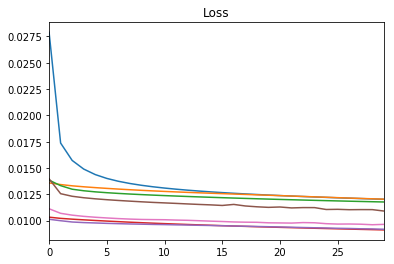

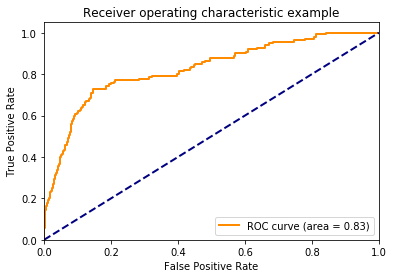

--- Initialization time: 597.2849042415619 seconds ---


In [15]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []
cl_buf_tmp = []
cl_buf = []
cl_notin_buf_tmp = []
cl_notin_buf = []
start_time = time.time()
prediction2 = []

len_nbuf = []
len_abuf = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for ids in range(len(test_set_list)):
#for data in test_set_list:
        data = test_set_list[ids]
     
        if count % 100 == 0:
            print(count,":",len(n_buf),", ",len(a_buf))
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma) # (8*30,)
        #scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in np.array(scores).reshape(batch_num,step_num)]
        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err
        
#       for index,value in enumerate(pd.DataFrame(pred)):
        for i in range(pd.DataFrame(pred).shape[0]):#loop batch_num
            index = i
            value=pd.DataFrame(pred).iloc[i,:]
            
            if value[value>threshold].size>=4: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf += [df[index,x,:] for x in range(step_num)]
                 
                    #err_abuf.append(e[index*step_num:(index+1)*step_num])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                    prediction2 +=[1]
                else:
                    #print("FP")
                    #err_nbuf.append(e[index])
                    err_nbuf =np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    n_buf += [df[index,x,:] for x in range(step_num)]
                    prediction2 +=[2]
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                    prediction2 += [3]
                else:
                    #err_nbuf.append(e[index])
                    err_nbuf = np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    prediction2 +=[4]
        count +=1
        
        
        #n_buf = list(np.concatenate(n_buf,axis=0)) if len(n_buf) != 0 else list(n_buf)
        #a_buf = list(np.concatenate(a_buf,axis=0)) if len(a_buf) != 0 else list(a_buf)
        
        if len(n_buf)>=batch_num*step_num*100 and len(a_buf) !=0:
            while (len(a_buf) < batch_num*step_num):
                a_buf += a_buf
            
            B = len(n_buf) //(batch_num*step_num)
            n_buf = n_buf[:batch_num*step_num*B]
            A = len(a_buf)//(batch_num*step_num)
            a_buf = a_buf[:batch_num*step_num*A]
            
            print("retrain at %d batch"%count)
            loss_list_all=[]

            #datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            datalist = np.array(n_buf[:batch_num*step_num*(B-1)]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf[batch_num*step_num*(B-1):]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(30):
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            
            #err_nbuf_tmp = np.array(err_nbuf).reshape(-1,elem_num)
            #mu,sigma = get_musigma(err_nbuf_tmp,mu,sigma)   

      

            print("Parameters updated! new threshold %.3f"%threshold)
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
            err_nbuf = []
            err_abuf = []

fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()
print("--- Initialization time: %s seconds ---" % (time.time() - start_time))